<a href="https://colab.research.google.com/github/Elshraby/DeepAerofoil/blob/main/Results_26_Apr_BasicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install deap pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.5 MB/s eta 0:00:00


In [7]:
import random
import numpy as np
import torch

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
# --- Dataset and Model for VAWT ---

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset
class VAWTDataset(Dataset):
    """ Custom dataset for vertical-axis wind turbine design data. """
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data.dropna(inplace=True)

        self.num_feature_columns = [
            'Number of Blades', 'Cord Length', 'Height',
            'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio'
        ]
        self.airfoil_column = 'Airfoil'
        self.target_column = 'Power Coefficient'

        self.num_features = self.data[self.num_feature_columns].values.astype(np.float32)

        airfoil_cat = self.data[self.airfoil_column].astype('category')
        self.airfoil_type = airfoil_cat.cat.codes.values.astype(np.int64)

        # Save mapping for airfoil name ↔ code
        self.airfoil_mapping = dict(enumerate(airfoil_cat.cat.categories))

        self.targets = self.data[self.target_column].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'num_features': torch.tensor(self.num_features[idx]),
            'airfoil_type': torch.tensor(self.airfoil_type[idx]),
            'target': torch.tensor(self.targets[idx])
        }

# Neural Network
class StandardVAWTNet(nn.Module):
    """ Standard MLP model for predicting turbine Cp. """
    def __init__(self, num_feature_size, airfoil_vocab_size, emb_size=4, hidden_size=128):
        super(StandardVAWTNet, self).__init__()
        self.airfoil_embedding = nn.Embedding(airfoil_vocab_size, emb_size)

        input_size = num_feature_size + emb_size

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, num_features, airfoil_type):
        emb = self.airfoil_embedding(airfoil_type)
        combined = torch.cat([num_features, emb], dim=1)
        return self.model(combined)

In [9]:
import torch.optim as optim
import json

# Training
def train_model(model, dataloader, num_epochs=500, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in dataloader:
            inputs = batch['num_features']
            airfoil_types = batch['airfoil_type']
            targets = batch['target']

            optimizer.zero_grad()
            outputs = model(inputs, airfoil_types)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.6f}")

    print("Training complete.")

# Saving
def save_model(model, filepath='vawt_model.pth', metadata_file='model_metadata.json', **hyperparams):
    # Force pure Python types for JSON
    clean_hyperparams = {k: int(v) if isinstance(v, (np.integer, np.int64)) else v for k, v in hyperparams.items()}
    torch.save(model.state_dict(), filepath)
    with open(metadata_file, 'w') as f:
        json.dump(clean_hyperparams, f, indent=4)
    print(f"Model and metadata saved successfully.")

# Loading
def load_model(model_class, model_filepath='vawt_model.pth', metadata_filepath='model_metadata.json'):
    with open(metadata_filepath, 'r') as f:
        hyperparams = json.load(f)

    model = model_class(
        num_feature_size=hyperparams["num_feature_size"],
        airfoil_vocab_size=hyperparams["airfoil_vocab_size"],
        emb_size=hyperparams["emb_size"],
        hidden_size=hyperparams["hidden_size"]
    )
    model.load_state_dict(torch.load(model_filepath))
    model.eval()
    print("Model loaded successfully.")
    return model

# Prediction (now using airfoil name, not code)
def predict(model, sample_num_features, sample_airfoil_name, airfoil_mapping):
    code_lookup = {v: k for k, v in airfoil_mapping.items()}

    if sample_airfoil_name not in code_lookup:
        raise ValueError(f"Airfoil '{sample_airfoil_name}' not recognized. Available: {list(code_lookup.keys())}")

    airfoil_code = code_lookup[sample_airfoil_name]

    model.eval()
    with torch.no_grad():
        num_features_tensor = torch.tensor([sample_num_features], dtype=torch.float32)
        airfoil_tensor = torch.tensor([airfoil_code], dtype=torch.int64)
        prediction = model(num_features_tensor, airfoil_tensor)
    return prediction.item()

In [10]:
# Load dataset
dataset = VAWTDataset('Data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
input_dim = len(dataset.num_feature_columns)
airfoil_vocab_size = int(dataset.airfoil_type.max()) + 1

model = StandardVAWTNet(input_dim, airfoil_vocab_size)

# Train
train_model(model, dataloader, num_epochs=500, learning_rate=1e-3)

# Save
hyperparams = {
    "num_feature_size": int(input_dim),
    "airfoil_vocab_size": int(airfoil_vocab_size),
    "emb_size": 4,
    "hidden_size": 128,
}
save_model(model, **hyperparams)

Epoch [50/500], Loss: 0.003772
Epoch [100/500], Loss: 0.001869
Epoch [150/500], Loss: 0.001213
Epoch [200/500], Loss: 0.000952
Epoch [250/500], Loss: 0.000936
Epoch [300/500], Loss: 0.000742
Epoch [350/500], Loss: 0.000665
Epoch [400/500], Loss: 0.000575
Epoch [450/500], Loss: 0.000611
Epoch [500/500], Loss: 0.000530
Training complete.
Model and metadata saved successfully.


In [19]:
# Load dataset (again to get airfoil mappings)
dataset = VAWTDataset('Data.csv')

# Load trained model
model = load_model(StandardVAWTNet)

# Predict
sample_num_features = [3, 0.18, 0.4, 0.42, 0, 7.0, 0.80356]  # Example input
sample_airfoil_name = "EN0005"  # Enter airfoil name directly

predicted_Cp = predict(model, sample_num_features, sample_airfoil_name, dataset.airfoil_mapping)
print(f"Predicted Power Coefficient (Cp): {predicted_Cp:.4f}")

Model loaded successfully.
Predicted Power Coefficient (Cp): 0.1274


True Value

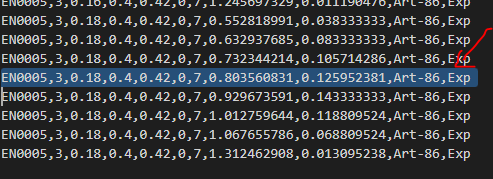